$\newcommand{\vct}[1]{\boldsymbol{#1}}
\newcommand{\mtx}[1]{\mathbf{#1}}
\newcommand{\tr}{^\mathrm{T}}
\newcommand{\reals}{\mathbb{R}}
\newcommand{\lpa}{\left(}
\newcommand{\rpa}{\right)}
\newcommand{\lsb}{\left[}
\newcommand{\rsb}{\right]}
\newcommand{\lbr}{\left\lbrace}
\newcommand{\rbr}{\right\rbrace}
\newcommand{\fset}[1]{\lbr #1 \rbr}
\newcommand{\pd}[2]{\frac{\partial #1}{\partial #2}}$

# Multiple layer models

In this notebook we will explore network models with multiple layers of transformations. This will build upon the single-layer affine model we looked at in the previous notebook and use material covered in the [second](http://www.inf.ed.ac.uk/teaching/courses/mlp/2017-18/mlp02-sln.pdf) and [third](http://www.inf.ed.ac.uk/teaching/courses/mlp/2017-18/mlp03-mlp.pdf) lectures.

You will need to use these models for the experiments you will be running in the first coursework so part of the aim of this lab will be to get you familiar with how to construct multiple layer models in our framework and how to train them.

## What is a layer?

Often when discussing (neural) network models, a network layer is taken to mean an input to output transformation of the form

\begin{equation}
    \vct{y} = \vct{f}(\mtx{W} \vct{x} + \vct{b})
    \qquad
    \Leftrightarrow
    \qquad
    y_k = f\lpa\sum_{d=1}^D \lpa W_{kd} x_d \rpa + b_k \rpa
\end{equation}

where $\mtx{W}$ and $\vct{b}$ parameterise an affine transformation as discussed in the previous notebook, and $f$ is a function applied elementwise to the result of the affine transformation. For example a common choice for $f$ is the logistic sigmoid function 
\begin{equation}
  f(u) = \frac{1}{1 + \exp(-u)}.
\end{equation}

In the second lecture slides you were shown how to train a model consisting of an affine transformation followed by the elementwise logistic sigmoid using gradient descent. This was referred to as a 'sigmoid single-layer network'.

In the previous notebook we also referred to single-layer models, where in that case the layer was an affine transformation, with you implementing the various necessary methods for the `AffineLayer` class before using an instance of that class within a `SingleLayerModel` on a regression problem. We could in that case consider the function $f$ to simply be the identity function $f(u) = u$. In the code for the labs we will however use a slightly different convention. Here we will consider the affine transformations and subsequent elementwise function $f$ to each be a separate transformation layer. 

This will mean we can combine our already implemented `AffineLayer` class with any non-linear function applied to the outputs just by implementing a layer object for the relevant non-linearity and then stacking the two layers together. An alternative would be to have our new layer objects inherit from `AffineLayer` and then call the relevant parent class methods in the child class however this would mean we need to include a lot of the same boilerplate code in every new class.

To give a concrete example, in the `mlp.layers` module there is a definition for a `SigmoidLayer` equivalent to the following (documentation strings have been removed here for brevity)

```python
class SigmoidLayer(Layer):

    def fprop(self, inputs):
        return 1. / (1. + np.exp(-inputs))

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        return grads_wrt_outputs * outputs * (1. - outputs)
```

As you can see this `SigmoidLayer` class has a very lightweight definition, defining just two key methods:

  * `fprop` which takes a batch of activations at the input to the layer and forward propagates them to produce activates at the outputs (directly equivalently to the `fprop` method you implemented for then `AffineLayer` in the previous notebook),
  * `brop` which takes a batch of gradients with respect to the outputs of the layer and back-propagates them to calculate gradients with respect to the inputs of the layer (explained in more detail below).
  
This `SigmoidLayer` class only implements the logistic sigmoid non-linearity transformation and so does not have any parameters. Therefore unlike `AffineLayer` it is derived directly from the base `Layer` class rather than `LayerWithParameters` and does not need to implement `grads_wrt_params` or `params` methods. 

To create a model consisting of an affine transformation followed by applying an elementwise logistic sigmoid transformation we first create a list of the two layer objects (in the order they are applied from inputs to outputs) and then use this to instantiate a new `MultipleLayerModel` object:

```python
from mlp.layers import AffineLayer, SigmoidLayer
from mlp.models import MultipleLayerModel

layers = [AffineLayer(input_dim, output_dim), SigmoidLayer()]
model = MultipleLayerModel(layers)
```

Because of the modular way in which the layers are defined we can also stack an arbitrarily long sequence of layers together to produce deeper models. For instance the following would define a model consisting of three pairs of affine and logistic sigmoid transformations.

```python
model = MultipleLayerModel([
    AffineLayer(input_dim, hidden_dim), SigmoidLayer(),
    AffineLayer(hidden_dim, hidden_dim), SigmoidLayer(),
    AffineLayer(hidden_dim, output_dim), SigmoidLayer(),
])
```

## Back-propagation of gradients
  
To allow training models consisting of a stack of multiple layers, all layers need to implement a `bprop` method in addition to the `fprop` we encountered in the previous week. 

The `bprop` method takes gradients of an error function with respect to the *outputs* of a layer and uses these gradients to calculate gradients of the error function with respect to the *inputs* of a layer. As the inputs to a non-input layer in a multiple-layer model consist of the outputs of the previous layer, this means we can calculate the gradients of the error function with respect to the outputs of every layer in the model by iteratively propagating the gradients backwards through the layers of the model (i.e. from the last to first layer), hence the term 'back-propagation' or 'bprop' for short. A block diagram illustrating this is shown for a three layer model below.

<img src='res/fprop-bprop-block-diagram.png' />

For a layer with parameters, the gradients with respect to the layer outputs are required to calculate gradients with respect to the layer parameters. Therefore by combining back-propagation of gradients through the model with computing the gradients with respect to parameters in the relevant layers we can calculate gradients of the error function with respect to all of the parameters of a multiple-layer model in a very efficient manner (in fact the computational cost of computing gradients with respect to all of the parameters of the model using this method will only be a constant factor times the cost of calculating the model outputs in the forward pass).

We so far have abstractly talked about calculating gradients with respect to the inputs of a layer using gradients with respect to the layer outputs. More concretely we will be using the chain rule for derivatives to do this, similarly to how we used the chain rule in exercise 4 of the previous notebook to calculate gradients with respect to the parameters of an affine layer given gradients with respect to the outputs of the layer.

In particular if our layer has a batch of $B$ vector inputs each of dimension $D$, $\fset{\vct{x}^{(b)}}_{b=1}^B$, and produces a batch of $B$ vector outputs each of dimension $K$, $\fset{\vct{y}^{(b)}}_{b=1}^B$,  then we can calculate the gradient with respect to the $d^\textrm{th}$ dimension of the $b^{\textrm{th}}$ input given the gradients with respect to the $b^{\textrm{th}}$ output using

\begin{equation}
    \pd{E}{x^{(b)}_d} = \sum_{k=1}^K \lpa \pd{E}{y^{(b)}_k} \pd{y^{(b)}_k}{x^{(b)}_d} \rpa.
\end{equation}

Mathematically therefore the `bprop` method takes an array of gradients with respect to the outputs $\pd{E}{y^{(b)}_k}$ and applies a sum-product operation with the partial derivatives of each output with respect to each input $\pd{y^{(b)}_k}{x^{(b)}_d}$ to produce gradients with respect to the inputs of the layer $\pd{E}{x^{(b)}_d}$.

For the affine transformation used in the `AffineLayer` implemented last week, i.e a forward propagation corresponding to 

\begin{equation}
    y^{(b)}_k = \sum_{d=1}^D \lpa W_{kd} x^{(b)}_d \rpa + b_k
\end{equation}

then the corresponding partial derivatives of layer outputs with respect to inputs are

\begin{equation}
    \pd{y^{(b)}_k}{x^{(b)}_d} = W_{kd}
\end{equation}

and so the back-propagation method for the `AffineLayer` takes the following form

\begin{equation}
    \pd{E}{x^{(b)}_d} = \sum_{k=1}^K \lpa \pd{E}{y^{(b)}_k} W_{kd} \rpa.
\end{equation}

This can be efficiently implemented in NumPy using the `dot` function

```python
class AffineLayer(LayerWithParameters):

    # ... [implementation of remaining methods from previous week] ...
    
    def bprop(self, inputs, outputs, grads_wrt_outputs):
        return grads_wrt_outputs.dot(self.weights)
```

An important special case applies when the outputs of a layer are an elementwise function of the inputs such that $y^{(b)}_k$ only depends on $x^{(b)}_d$ when $d = k$. In this case the partial derivatives $\pd{y^{(b)}_k}{x^{(b)}_d}$ will be zero for $k \neq d$ and so the above summation collapses to a single term, giving

\begin{equation}
    \pd{E}{x^{(b)}_d} = \pd{E}{y^{(b)}_d} \pd{y^{(b)}_d}{x^{(b)}_d}
\end{equation}

i.e. to calculate the gradient with respect to the $b^{\textrm{th}}$ input vector we just perform an elementwise multiplication of the gradient with respect to the $b^{\textrm{th}}$ output vector with the vector of derivatives of the outputs with respect to the inputs. This case applies to the `SigmoidLayer` and to all other layers applying an elementwise function to their inputs.

For the logistic sigmoid layer we have that

\begin{equation}
    y^{(b)}_d = \frac{1}{1 + \exp(-x^{(b)}_d)}
    \qquad
    \Rightarrow
    \qquad
    \pd{y^{(b)}_d}{x^{(b)}_d} = 
    \frac{\exp(-x^{(b)}_d)}{\lsb 1 + \exp(-x^{(b)}_d) \rsb^2} =
     y^{(b)}_d \lsb 1 -  y^{(b)}_d  \rsb
\end{equation}

which you should now be able relate to the implementation of `SigmoidLayer.bprop` given earlier:

```python
class SigmoidLayer(Layer):

    def fprop(self, inputs):
        return 1. / (1. + np.exp(-inputs))

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        return grads_wrt_outputs * outputs * (1. - outputs)
```

## Exercise 1: training a softmax model on MNIST

For this first exercise we will train a model consisting of an affine transformation plus softmax on a multiclass classification task: classifying the digit labels for handwritten digit images from the MNIST data set introduced in the first notebook.

First run the cell below to import the necessary modules and classes and to load the MNIST data provider objects. As it takes a little while to load the MNIST data from disk into memory it is worth loading the data providers just once in a separate cell like this rather than recreating the objects for every training run.

We are loading two data provider objects here - one corresponding to the training data set and a second to use as a *validation* data set. This is data we do not train the model on but measure the performance of the trained model on to assess its ability to *generalise* to unseen data. 

If you are in the Monday or Tuesday lab sessions you will not yet have had the lecture introducing the concepts of generalisation and validation data sets (though those doing MLPR alongside this course should already be familiar with these ideas). As you will need to report both training and validation set performances in your experiments for the first coursework assignment we are providing code here to give an example of how to do this.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
from mlp.layers import AffineLayer, SoftmaxLayer, SigmoidLayer
from mlp.errors import CrossEntropyError, CrossEntropySoftmaxError
from mlp.models import SingleLayerModel, MultipleLayerModel
from mlp.initialisers import UniformInit
from mlp.learning_rules import GradientDescentLearningRule
from mlp.data_providers import MNISTDataProvider
from mlp.optimisers import Optimiser
%matplotlib inline
plt.style.use('ggplot')

# Seed a random number generator
seed = 6102016 
rng = np.random.RandomState(seed)

# Set up a logger object to print info about the training run to stdout
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.handlers = [logging.StreamHandler()]

# Create data provider objects for the MNIST data set
train_data = MNISTDataProvider('train', rng=rng)
valid_data = MNISTDataProvider('valid', rng=rng)
input_dim, output_dim = 784, 10

To minimise replication of code and allow you to run experiments more quickly a helper function is provided below which trains a model and plots the evolution of the error and classification accuracy of the model (on both training and validation sets) over training.

In [3]:
def train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval):

    # As well as monitoring the error over training also monitor classification
    # accuracy i.e. proportion of most-probable predicted classes being equal to targets
    data_monitors={'acc': lambda y, t: (y.argmax(-1) == t.argmax(-1)).mean()}

    # Use the created objects to initialise a new Optimiser instance.
    optimiser = Optimiser(
        model, error, learning_rule, train_data, valid_data, data_monitors)

    # Run the optimiser for 5 epochs (full passes through the training set)
    # printing statistics every epoch.
    stats, keys, train_time = optimiser.train(num_epochs=num_epochs, stats_interval=stats_interval)

    # Plot the change in the validation and training set error over training.
    fig_1 = plt.figure(figsize=(8, 4))
    ax_1 = fig_1.add_subplot(111)
    for k in ['error(train)', 'error(valid)']:
        ax_1.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_1.legend(loc=0)
    ax_1.set_xlabel('Epoch number')

    # Plot the change in the validation and training set accuracy over training.
    fig_2 = plt.figure(figsize=(8, 4))
    ax_2 = fig_2.add_subplot(111)
    for k in ['acc(train)', 'acc(valid)']:
        ax_2.plot(np.arange(1, stats.shape[0]) * stats_interval, 
                  stats[1:, keys[k]], label=k)
    ax_2.legend(loc=0)
    ax_2.set_xlabel('Epoch number')
    
    return stats, keys, run_time, fig_1, ax_1, fig_2, ax_2

Running the cell below will create a model consisting of an affine layer follower by a softmax transformation and train it on the MNIST data set by minimising the multi-class cross entropy error function using a basic gradient descent learning rule. By using the helper function defined above, at the end of training curves of the evolution of the error function and also classification accuracy of the model over the training epochs will be plotted.

You should try running the code for various settings of the training hyperparameters defined at the beginning of the cell to get a feel for how these affect how training proceeds. You may wish to create multiple copies of the cell below to allow you to keep track of and compare the results across different hyperparameter settings.

### Varying initialisation scale

<span style="color:red">First try a few different parameter initialisation scales</span>

#### `init_scale = 0.01`

Epoch 5: 1.1s to complete
    error(train)=3.11e-01, acc(train)=9.13e-01, error(valid)=2.92e-01, acc(valid)=9.18e-01
Epoch 10: 0.7s to complete
    error(train)=2.88e-01, acc(train)=9.20e-01, error(valid)=2.77e-01, acc(valid)=9.23e-01
Epoch 15: 1.1s to complete
    error(train)=2.79e-01, acc(train)=9.22e-01, error(valid)=2.70e-01, acc(valid)=9.25e-01
Epoch 20: 0.8s to complete
    error(train)=2.73e-01, acc(train)=9.24e-01, error(valid)=2.67e-01, acc(valid)=9.25e-01
Epoch 25: 0.9s to complete
    error(train)=2.67e-01, acc(train)=9.26e-01, error(valid)=2.64e-01, acc(valid)=9.27e-01
Epoch 30: 0.7s to complete
    error(train)=2.63e-01, acc(train)=9.27e-01, error(valid)=2.62e-01, acc(valid)=9.27e-01
Epoch 35: 0.7s to complete
    error(train)=2.60e-01, acc(train)=9.28e-01, error(valid)=2.62e-01, acc(valid)=9.29e-01
Epoch 40: 0.7s to complete
    error(train)=2.58e-01, acc(train)=9.28e-01, error(valid)=2.60e-01, acc(valid)=9.28e-01
Epoch 45: 0.7s to complete
    error(train)=2.56e-01, acc

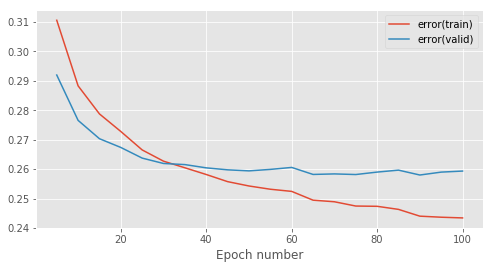

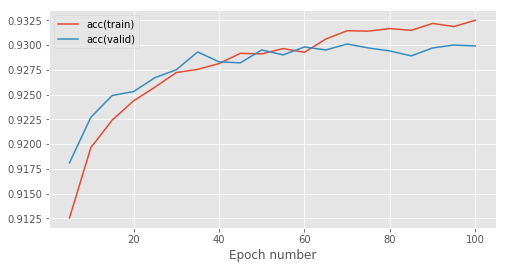

In [4]:
#### `init_scale = 0.1`

Epoch 5: 3.8s to complete
    error(train)=3.11e-01, acc(train)=9.13e-01, error(valid)=2.92e-01, acc(valid)=9.18e-01
Epoch 10: 4.0s to complete
    error(train)=2.89e-01, acc(train)=9.20e-01, error(valid)=2.77e-01, acc(valid)=9.23e-01
Epoch 15: 3.7s to complete
    error(train)=2.79e-01, acc(train)=9.22e-01, error(valid)=2.70e-01, acc(valid)=9.24e-01
Epoch 20: 5.4s to complete
    error(train)=2.72e-01, acc(train)=9.24e-01, error(valid)=2.66e-01, acc(valid)=9.26e-01
Epoch 25: 4.7s to complete
    error(train)=2.68e-01, acc(train)=9.25e-01, error(valid)=2.66e-01, acc(valid)=9.26e-01
Epoch 30: 4.2s to complete
    error(train)=2.63e-01, acc(train)=9.27e-01, error(valid)=2.62e-01, acc(valid)=9.26e-01
Epoch 35: 4.0s to complete
    error(train)=2.60e-01, acc(train)=9.28e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 40: 4.3s to complete
    error(train)=2.59e-01, acc(train)=9.28e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 45: 4.5s to complete
    error(train)=2.55e-01, acc

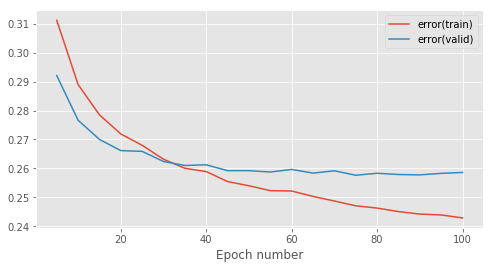

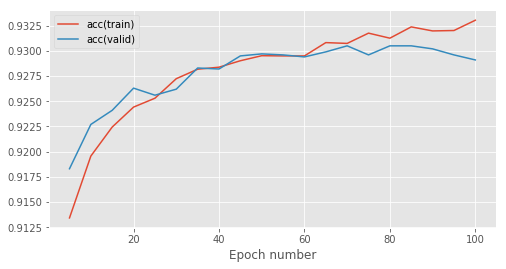

In [4]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, output_dim, param_init, param_init),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

#### `init_scale = 0.5`

Epoch 5: 3.7s to complete
    error(train)=3.38e-01, acc(train)=9.03e-01, error(valid)=3.17e-01, acc(valid)=9.11e-01
Epoch 10: 4.3s to complete
    error(train)=3.06e-01, acc(train)=9.13e-01, error(valid)=2.94e-01, acc(valid)=9.17e-01
Epoch 15: 3.3s to complete
    error(train)=2.92e-01, acc(train)=9.17e-01, error(valid)=2.83e-01, acc(valid)=9.20e-01
Epoch 20: 5.5s to complete
    error(train)=2.82e-01, acc(train)=9.20e-01, error(valid)=2.77e-01, acc(valid)=9.22e-01
Epoch 25: 3.8s to complete
    error(train)=2.77e-01, acc(train)=9.22e-01, error(valid)=2.75e-01, acc(valid)=9.22e-01
Epoch 30: 4.3s to complete
    error(train)=2.71e-01, acc(train)=9.24e-01, error(valid)=2.71e-01, acc(valid)=9.25e-01
Epoch 35: 3.9s to complete
    error(train)=2.67e-01, acc(train)=9.25e-01, error(valid)=2.69e-01, acc(valid)=9.26e-01
Epoch 40: 4.4s to complete
    error(train)=2.65e-01, acc(train)=9.27e-01, error(valid)=2.68e-01, acc(valid)=9.26e-01
Epoch 45: 4.2s to complete
    error(train)=2.61e-01, acc

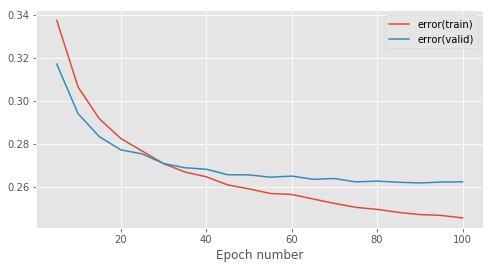

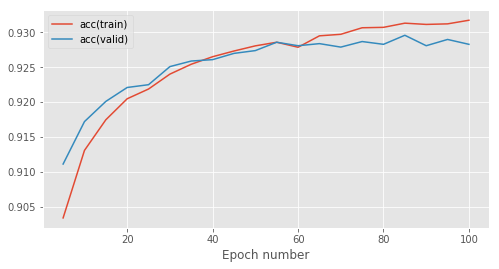

In [5]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.5  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, output_dim, param_init, param_init),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

|`init_scale`| Final `error(train)` | Final `error(valid)` |
|------------|----------------------|----------------------|
| 0.01       | 2.43e-01             | 2.58e-01             |
| 0.1        | 2.43e-01             | 2.59e-01             |
| 0.5        | 2.45e-01             | 2.62e-01             |

<span style="color:red">
Larger initialisation scale of 0.5 seems to give slightly slower initial learning than smaller scales of 0.1 and 0.01 however difference is only slight suggesting for this shallow architecure training performance is not particularly sensitive to initialisation scale.
</span>

### Varying learning rate

<span style="color:red">Now let's try some different values for learning rate.</span>

#### `learning_rate = 0.05`

Epoch 5: 4.0s to complete
    error(train)=3.41e-01, acc(train)=9.05e-01, error(valid)=3.16e-01, acc(valid)=9.12e-01
Epoch 10: 4.0s to complete
    error(train)=3.10e-01, acc(train)=9.14e-01, error(valid)=2.92e-01, acc(valid)=9.18e-01
Epoch 15: 5.1s to complete
    error(train)=2.97e-01, acc(train)=9.18e-01, error(valid)=2.82e-01, acc(valid)=9.21e-01
Epoch 20: 4.1s to complete
    error(train)=2.88e-01, acc(train)=9.20e-01, error(valid)=2.76e-01, acc(valid)=9.23e-01
Epoch 25: 4.4s to complete
    error(train)=2.83e-01, acc(train)=9.21e-01, error(valid)=2.73e-01, acc(valid)=9.24e-01
Epoch 30: 3.9s to complete
    error(train)=2.77e-01, acc(train)=9.22e-01, error(valid)=2.69e-01, acc(valid)=9.24e-01
Epoch 35: 3.7s to complete
    error(train)=2.74e-01, acc(train)=9.24e-01, error(valid)=2.67e-01, acc(valid)=9.25e-01
Epoch 40: 4.0s to complete
    error(train)=2.72e-01, acc(train)=9.24e-01, error(valid)=2.66e-01, acc(valid)=9.26e-01
Epoch 45: 3.7s to complete
    error(train)=2.68e-01, acc

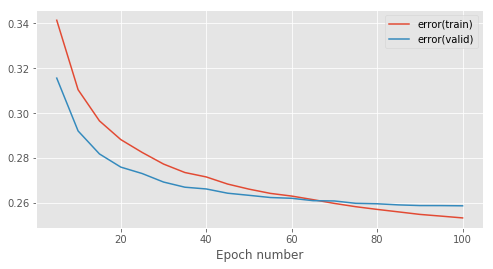

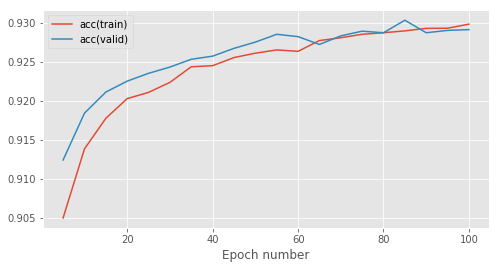

In [6]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.05  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, output_dim, param_init, param_init),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

#### `learning_rate = 0.1`

Epoch 5: 5.1s to complete
    error(train)=3.11e-01, acc(train)=9.13e-01, error(valid)=2.92e-01, acc(valid)=9.18e-01
Epoch 10: 3.4s to complete
    error(train)=2.89e-01, acc(train)=9.20e-01, error(valid)=2.77e-01, acc(valid)=9.23e-01
Epoch 15: 3.8s to complete
    error(train)=2.79e-01, acc(train)=9.22e-01, error(valid)=2.70e-01, acc(valid)=9.24e-01
Epoch 20: 3.4s to complete
    error(train)=2.72e-01, acc(train)=9.24e-01, error(valid)=2.66e-01, acc(valid)=9.26e-01
Epoch 25: 4.3s to complete
    error(train)=2.68e-01, acc(train)=9.25e-01, error(valid)=2.66e-01, acc(valid)=9.26e-01
Epoch 30: 3.9s to complete
    error(train)=2.63e-01, acc(train)=9.27e-01, error(valid)=2.62e-01, acc(valid)=9.26e-01
Epoch 35: 4.5s to complete
    error(train)=2.60e-01, acc(train)=9.28e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 40: 5.9s to complete
    error(train)=2.59e-01, acc(train)=9.28e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 45: 4.0s to complete
    error(train)=2.55e-01, acc

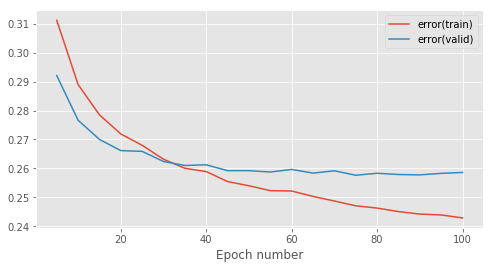

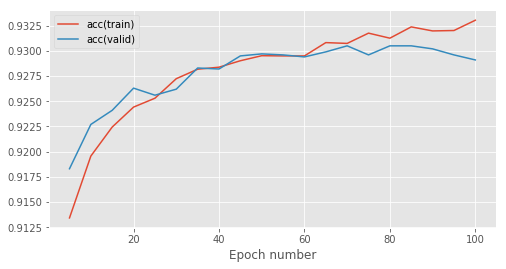

In [7]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, output_dim, param_init, param_init),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

#### `learning_rate = 0.2`

Epoch 5: 3.5s to complete
    error(train)=2.90e-01, acc(train)=9.19e-01, error(valid)=2.77e-01, acc(valid)=9.22e-01
Epoch 10: 3.8s to complete
    error(train)=2.75e-01, acc(train)=9.23e-01, error(valid)=2.69e-01, acc(valid)=9.25e-01
Epoch 15: 5.3s to complete
    error(train)=2.66e-01, acc(train)=9.26e-01, error(valid)=2.64e-01, acc(valid)=9.26e-01
Epoch 20: 4.3s to complete
    error(train)=2.60e-01, acc(train)=9.28e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 25: 4.9s to complete
    error(train)=2.57e-01, acc(train)=9.28e-01, error(valid)=2.64e-01, acc(valid)=9.27e-01
Epoch 30: 5.0s to complete
    error(train)=2.53e-01, acc(train)=9.29e-01, error(valid)=2.61e-01, acc(valid)=9.30e-01
Epoch 35: 4.2s to complete
    error(train)=2.50e-01, acc(train)=9.30e-01, error(valid)=2.60e-01, acc(valid)=9.30e-01
Epoch 40: 4.0s to complete
    error(train)=2.49e-01, acc(train)=9.31e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 45: 4.4s to complete
    error(train)=2.45e-01, acc

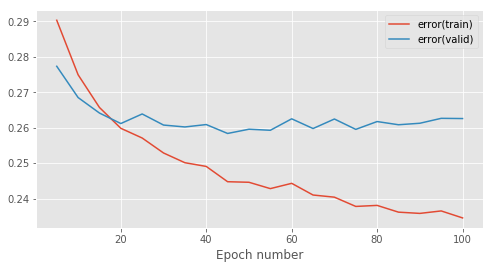

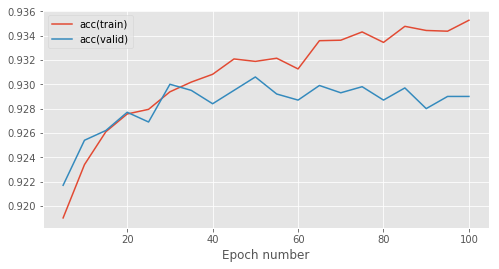

In [8]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.2  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, output_dim, param_init, param_init),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

#### `learning_rate = 0.5`

Epoch 5: 3.5s to complete
    error(train)=2.79e-01, acc(train)=9.20e-01, error(valid)=2.74e-01, acc(valid)=9.23e-01
Epoch 10: 3.7s to complete
    error(train)=2.68e-01, acc(train)=9.24e-01, error(valid)=2.72e-01, acc(valid)=9.26e-01
Epoch 15: 3.9s to complete
    error(train)=2.55e-01, acc(train)=9.28e-01, error(valid)=2.66e-01, acc(valid)=9.26e-01
Epoch 20: 3.5s to complete
    error(train)=2.49e-01, acc(train)=9.31e-01, error(valid)=2.61e-01, acc(valid)=9.29e-01
Epoch 25: 4.3s to complete
    error(train)=2.52e-01, acc(train)=9.29e-01, error(valid)=2.73e-01, acc(valid)=9.25e-01
Epoch 30: 3.5s to complete
    error(train)=2.47e-01, acc(train)=9.31e-01, error(valid)=2.70e-01, acc(valid)=9.27e-01
Epoch 35: 3.2s to complete
    error(train)=2.44e-01, acc(train)=9.32e-01, error(valid)=2.69e-01, acc(valid)=9.27e-01
Epoch 40: 4.1s to complete
    error(train)=2.44e-01, acc(train)=9.32e-01, error(valid)=2.72e-01, acc(valid)=9.26e-01
Epoch 45: 4.3s to complete
    error(train)=2.36e-01, acc

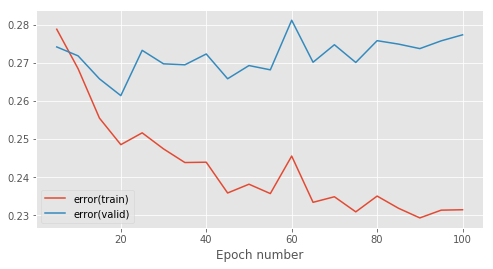

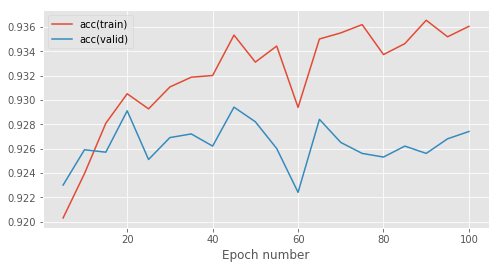

In [9]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.5  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel([
    AffineLayer(input_dim, output_dim, param_init, param_init),
    SoftmaxLayer()
])

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

|`learning_rate`| Final `error(train)` | Final `error(valid)` |
|---------------|----------------------|----------------------|
| 0.05          | $2.53\times 10^{-1}$  | $2.59\times 10^{-1}$|
| 0.1           | $2.43\times 10^{-1}$  | $2.59\times 10^{-1}$|
| 0.2           | $2.35\times 10^{-1}$  | $2.63\times 10^{-1}$|
| 0.5           | $2.31\times 10^{-1}$  | $2.77\times 10^{-1}$|

<span style="color:red">
Increasing the learning rate, as would be expected, increase the speed of learning, with the final training error reached monotonically decreasing over the learning rates tested as the learning rate was increased. Note however the validation set error increases for larger learning rates - this suggests the model is overfitting to the data, with the larger learning rates causing the model to begin overfitting sooner - we could have afforded to halt learning earlier in these cases when there was no further improvement in the validation set error. Notice also the error curves for the largest learning rate value are much more noisy suggesting learning is becoming quite unstable with this large a step size, with a lot of the gradient descent steps overshooting and causing the error function value to increase.
</span>

### Optional extra: more efficient softmax gradient evaluation

In the lectures you were shown that for certain combinations of error function and final output layers, that the expressions for the gradients take particularly simple forms. 

In particular it can be shown that the combinations of 

  * logistic sigmoid output layer and binary cross entropy error function
  * softmax output layer and cross entropy error function
 
lead to particularly simple forms for the gradients of the error function with respect to the inputs to the final layer. In particular for the latter softmax and cross entropy error function case we have that

\begin{equation}
    y^{(b)}_k = \textrm{Softmax}_k\lpa\vct{x}^{(b)}\rpa = \frac{\exp(x^{(b)}_k)}{\sum_{d=1}^D \lbr \exp(x^{(b)}_d) \rbr}
    \qquad
    E^{(b)} = \textrm{CrossEntropy}\lpa\vct{y}^{(b)},\,\vct{t}^{(b)}\rpa = -\sum_{d=1}^D \lbr t^{(b)}_d \log(y^{(b)}_d) \rbr
\end{equation}

and it can be shown (this is an instructive mathematical exercise if you want a challenge!) that

\begin{equation}
    \pd{E^{(b)}}{x^{(b)}_d} = y^{(b)}_d - t^{(b)}_d.
\end{equation}

The combination of `CrossEntropyError` and `SoftmaxLayer` used to train the model above calculate this gradient less directly by first calculating the gradient of the error with respect to the model outputs in `CrossEntropyError.grad` and then back-propagating this gradient to the inputs of the softmax layer using `SoftmaxLayer.bprop`.

Rather than computing the gradient in two steps like this we can instead wrap the softmax transformation in to the definition of the error function and make use of the simpler gradient expression above. More explicitly we define an error function as follows

\begin{equation}
    E^{(b)} = \textrm{CrossEntropySoftmax}\lpa\vct{y}^{(b)},\,\vct{t}^{(b)}\rpa = -\sum_{d=1}^D \lbr t^{(b)}_d \log\lsb\textrm{Softmax}_d\lpa \vct{y}^{(b)}\rpa\rsb\rbr
\end{equation}

with corresponding gradient

\begin{equation}
    \pd{E^{(b)}}{y^{(b)}_d} = \textrm{Softmax}_d\lpa \vct{y}^{(b)}\rpa - t^{(b)}_d.
\end{equation}

The final layer of the model will then be an affine transformation which produces unbounded output values corresponding to the logarithms of the unnormalised predicted class probabilities. An implementation of this error function is provided in `CrossEntropySoftmaxError`. The cell below sets up a model with a single affine transformation layer and trains it on MNIST using this new cost. If you run it with equivalent hyperparameters to one of your runs with the alternative formulation above you should get identical error and classification curves (other than floating point error) but with a minor improvement in training speed.


Epoch 5: 0.9s to complete
    error(train)=3.12e-01, acc(train)=9.12e-01, error(valid)=2.93e-01, acc(valid)=9.18e-01
Epoch 10: 0.5s to complete
    error(train)=2.89e-01, acc(train)=9.19e-01, error(valid)=2.77e-01, acc(valid)=9.21e-01
Epoch 15: 0.7s to complete
    error(train)=2.80e-01, acc(train)=9.21e-01, error(valid)=2.72e-01, acc(valid)=9.23e-01
Epoch 20: 0.5s to complete
    error(train)=2.71e-01, acc(train)=9.25e-01, error(valid)=2.66e-01, acc(valid)=9.26e-01
Epoch 25: 0.5s to complete
    error(train)=2.67e-01, acc(train)=9.26e-01, error(valid)=2.65e-01, acc(valid)=9.26e-01
Epoch 30: 0.6s to complete
    error(train)=2.64e-01, acc(train)=9.28e-01, error(valid)=2.62e-01, acc(valid)=9.28e-01
Epoch 35: 0.5s to complete
    error(train)=2.60e-01, acc(train)=9.28e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 40: 0.8s to complete
    error(train)=2.58e-01, acc(train)=9.28e-01, error(valid)=2.61e-01, acc(valid)=9.28e-01
Epoch 45: 0.8s to complete
    error(train)=2.57e-01, acc

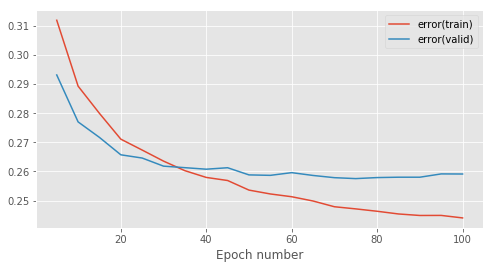

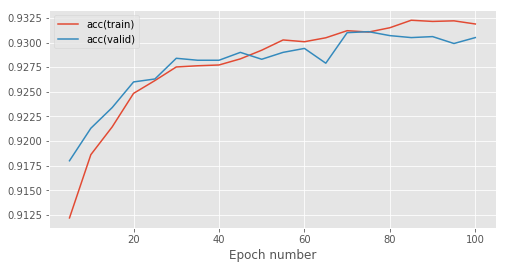

In [5]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine model (outputs are logs of unnormalised class probabilities)
model = SingleLayerModel(
    AffineLayer(input_dim, output_dim, param_init, param_init)
)

# Initialise the error object
error = CrossEntropySoftmaxError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

<span style="color:red">
This gives exactly the same training curves (and error / accuracy values over training) as the two runs with equivalent parameters above (second `init_scale` experiment and second `learning_rate` experiment).
</span>

<span style="color:red">
The times per epoch seems to be slightly lower on average (0.20s compared to 0.22s) suggesting the reformulation gives a small efficiency gain (though this will become less apparent in deeper architectures as the benefit only applies to the final layer).
</span>

## Exercise 2: training deeper models on MNIST

We are now going to investigate using deeper multiple-layer model archictures for the MNIST classification task. You should experiment with training models with two to five `AffineLayer` transformations interleaved with `SigmoidLayer` nonlinear transformations. Intermediate hidden layers between the input and output should have a dimension of 100. For example the `layers` definition of a model with two `AffineLayer` transformations would be

```python
layers = [
    AffineLayer(input_dim, 100),
    SigmoidLayer(),
    AffineLayer(100, output_dim),
    SoftmaxLayer()
]
```

If you read through the extension to the first exercise you may wish to use the `CrossEntropySoftmaxError` without the final `SoftmaxLayer`.

Use the code from the first exercise as a starting point and start with training hyperparameters which gave reasonable performance for the shallow architecture trained previously.

Some questions to investigate:

  * How does increasing the number of layers affect the model's performance on the training data set? And on the validation data set?
  * Do deeper models seem to be harder or easier to train (e.g. in terms of ease of choosing training hyperparameters to give good final performance and/or quick convergence)?
  * Do the models seem to be sensitive to the choice of the parameter initialisation range? Can you think of any reasons for why setting individual parameter initialisation scales for each `AffineLayer` in a model might be useful? Can you come up with (or find) any heuristics for setting the parameter initialisation scales?
  
You do not need to come up with explanations for all of these (though if you can that's great!), they are meant as prompts to get you thinking about the various issues involved in training multiple-layer models. 

You may wish to start with shorter pilot training runs (by decreasing the number of training epochs) for each of the model architectures to get an initial idea of appropriate hyperparameter settings before doing one or two longer training runs to assess the final performance of the architectures.

In [11]:
# disable logging by setting handler to dummy object
logger.handlers = [logging.NullHandler()]

### Models with two affine layers

Epoch 5: 2.0s to complete
    error(train)=3.06e-01, acc(train)=9.12e-01, error(valid)=2.82e-01, acc(valid)=9.17e-01
Epoch 10: 1.9s to complete
    error(train)=2.47e-01, acc(train)=9.29e-01, error(valid)=2.32e-01, acc(valid)=9.32e-01
Epoch 15: 1.9s to complete
    error(train)=2.07e-01, acc(train)=9.40e-01, error(valid)=2.00e-01, acc(valid)=9.44e-01
Epoch 20: 2.0s to complete
    error(train)=1.77e-01, acc(train)=9.49e-01, error(valid)=1.74e-01, acc(valid)=9.52e-01
Epoch 25: 2.4s to complete
    error(train)=1.55e-01, acc(train)=9.55e-01, error(valid)=1.57e-01, acc(valid)=9.56e-01
Epoch 30: 3.5s to complete
    error(train)=1.37e-01, acc(train)=9.61e-01, error(valid)=1.42e-01, acc(valid)=9.60e-01
Epoch 35: 2.1s to complete
    error(train)=1.23e-01, acc(train)=9.65e-01, error(valid)=1.32e-01, acc(valid)=9.64e-01
Epoch 40: 2.2s to complete
    error(train)=1.12e-01, acc(train)=9.69e-01, error(valid)=1.23e-01, acc(valid)=9.67e-01
Epoch 45: 1.8s to complete
    error(train)=1.01e-01, acc

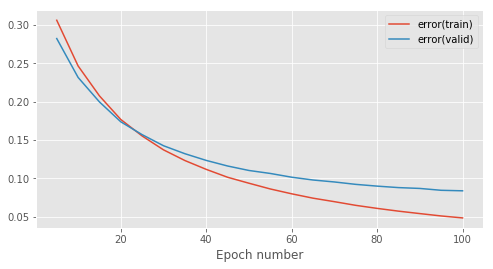

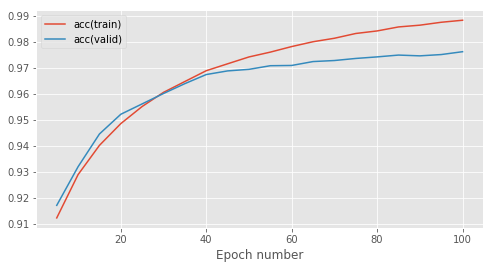

In [6]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel(layers = [
    AffineLayer(input_dim, 100),
    SigmoidLayer(),
    AffineLayer(100, output_dim),
    SoftmaxLayer()
]

)

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

In [13]:
j = 0
print('| init_scale | final error(train) | final error(valid) | final acc(train) | final acc(valid) |')
print('|------------|--------------------|--------------------|------------------|------------------|')
for init_scale in init_scales:
    print('| {0:.1f}        | {1:.2e}           | {2:.2e}           |  {3:.2f}            | {4:.2f}             |'
          .format(init_scale, 
                  final_errors_train[j], final_errors_valid[j],
                  final_accs_train[j], final_accs_valid[j]))
    j += 1

| init_scale | final error(train) | final error(valid) | final acc(train) | final acc(valid) |
|------------|--------------------|--------------------|------------------|------------------|
| 0.1        | 1.75e-01           | 1.72e-01           |  0.95            | 0.95             |
| 0.2        | 1.70e-01           | 1.69e-01           |  0.95            | 0.95             |
| 0.5        | 1.69e-01           | 1.71e-01           |  0.95            | 0.95             |
| 1.0        | 2.05e-01           | 2.07e-01           |  0.94            | 0.94             |


### Models with three affine layers

In [16]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel(layers = [
    AffineLayer(input_dim, 100),
    SigmoidLayer(),
    AffineLayer(100, 100),
    SigmoidLayer(),
    AffineLayer(100, output_dim),
    SoftmaxLayer()
]

)

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

Epoch 5: 3.5s to complete
    error(train)=4.02e-01, acc(train)=8.88e-01, error(valid)=3.74e-01, acc(valid)=8.99e-01
Epoch 10: 3.9s to complete
    error(train)=2.82e-01, acc(train)=9.19e-01, error(valid)=2.65e-01, acc(valid)=9.24e-01
Epoch 15: 2.9s to complete
    error(train)=2.25e-01, acc(train)=9.35e-01, error(valid)=2.13e-01, acc(valid)=9.40e-01
Epoch 20: 2.3s to complete
    error(train)=1.83e-01, acc(train)=9.47e-01, error(valid)=1.78e-01, acc(valid)=9.52e-01
Epoch 25: 2.2s to complete
    error(train)=1.54e-01, acc(train)=9.56e-01, error(valid)=1.54e-01, acc(valid)=9.58e-01
Epoch 30: 2.3s to complete
    error(train)=1.30e-01, acc(train)=9.63e-01, error(valid)=1.37e-01, acc(valid)=9.63e-01
Epoch 35: 2.4s to complete
    error(train)=1.13e-01, acc(train)=9.68e-01, error(valid)=1.25e-01, acc(valid)=9.65e-01
Epoch 40: 2.9s to complete
    error(train)=9.84e-02, acc(train)=9.72e-01, error(valid)=1.16e-01, acc(valid)=9.69e-01
Epoch 45: 2.5s to complete
    error(train)=8.59e-02, acc

In [17]:
j = 0
print('| init_scale | final error(train) | final error(valid) | final acc(train) | final acc(valid) |')
print('|------------|--------------------|--------------------|------------------|------------------|')
for init_scale in init_scales:
    print('| {0:.1f}        | {1:.2e}           | {2:.2e}           |  {3:.2f}            | {4:.2f}             |'
          .format(init_scale, 
                  final_errors_train[j], final_errors_valid[j],
                  final_accs_train[j], final_accs_valid[j]))
    j += 1

| init_scale | final error(train) | final error(valid) | final acc(train) | final acc(valid) |
|------------|--------------------|--------------------|------------------|------------------|
| 0.1        | 1.86e-01           | 1.83e-01           |  0.95            | 0.95             |
| 0.2        | 1.74e-01           | 1.75e-01           |  0.95            | 0.95             |
| 0.5        | 1.68e-01           | 1.75e-01           |  0.95            | 0.95             |
| 1.0        | 1.98e-01           | 2.10e-01           |  0.94            | 0.94             |


### Models with four affine layers

In [ ]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
init_scale = 0.1  # scale for random parameter initialisation
learning_rate = 0.1  # learning rate for gradient descent
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats

# Reset random number generator and data provider states on each run
# to ensure reproducibility of results
rng.seed(seed)
train_data.reset()
valid_data.reset()

# Alter data-provider batch size
train_data.batch_size = batch_size 
valid_data.batch_size = batch_size

# Create a parameter initialiser which will sample random uniform values
# from [-init_scale, init_scale]
param_init = UniformInit(-init_scale, init_scale, rng=rng)

# Create affine + softmax model
model = MultipleLayerModel(layers = [
    AffineLayer(input_dim, 100),
    SigmoidLayer(),
    AffineLayer(100, 100),
    SigmoidLayer(),
    AffineLayer(100, output_dim),
    SoftmaxLayer()
]

)

# Initialise a cross entropy error object
error = CrossEntropyError()

# Use a basic gradient descent learning rule
learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

_ = train_model_and_plot_stats(
    model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

In [19]:
j = 0
print('| init_scale | final error(train) | final error(valid) | final acc(train) | final acc(valid) |')
print('|------------|--------------------|--------------------|------------------|------------------|')
for init_scale in init_scales:
    print('| {0:.1f}        | {1:.2e}           | {2:.2e}           |  {3:.2f}            | {4:.2f}             |'
          .format(init_scale, 
                  final_errors_train[j], final_errors_valid[j],
                  final_accs_train[j], final_accs_valid[j]))
    j += 1

| init_scale | final error(train) | final error(valid) | final acc(train) | final acc(valid) |
|------------|--------------------|--------------------|------------------|------------------|
| 0.1        | 2.03e-03           | 1.35e-01           |  1.00            | 0.97             |
| 0.2        | 1.99e-03           | 1.17e-01           |  1.00            | 0.97             |
| 0.5        | 3.07e-03           | 1.34e-01           |  1.00            | 0.97             |
| 1.0        | 7.72e-03           | 1.62e-01           |  1.00            | 0.96             |


### Models with five affine layers

In [ ]:
# Set training run hyperparameters
batch_size = 100  # number of data points in a batch
num_epochs = 100  # number of training epochs to perform
stats_interval = 5  # epoch interval between recording and printing stats
learning_rate = 0.2  # learning rate for gradient descent

init_scales = [0.1, 0.2, 0.5, 1.]  # scale for random parameter initialisation
final_errors_train = []
final_errors_valid = []
final_accs_train = []
final_accs_valid = []

for init_scale in init_scales:

    print('-' * 80)
    print('learning_rate={0:.2f} init_scale={1:.2f}'
          .format(learning_rate, init_scale))
    print('-' * 80)
    # Reset random number generator and data provider states on each run
    # to ensure reproducibility of results
    rng.seed(seed)
    train_data.reset()
    valid_data.reset()

    # Alter data-provider batch size
    train_data.batch_size = batch_size 
    valid_data.batch_size = batch_size

    # Create a parameter initialiser which will sample random uniform values
    # from [-init_scale, init_scale]
    param_init = UniformInit(-init_scale, init_scale, rng=rng)

    # Create a model with five affine layers
    hidden_dim = 100
    model = MultipleLayerModel([
        AffineLayer(input_dim, hidden_dim, param_init, param_init),
        SigmoidLayer(),
        AffineLayer(hidden_dim, hidden_dim, param_init, param_init),
        SigmoidLayer(),
        AffineLayer(hidden_dim, hidden_dim, param_init, param_init),
        SigmoidLayer(),
        AffineLayer(hidden_dim, hidden_dim, param_init, param_init),
        SigmoidLayer(),
        AffineLayer(hidden_dim, output_dim, param_init, param_init)
    ])

    # Initialise a cross entropy error object
    error = CrossEntropySoftmaxError()

    # Use a basic gradient descent learning rule
    learning_rule = GradientDescentLearningRule(learning_rate=learning_rate)

    stats, keys, run_time, fig_1, ax_1, fig_2, ax_2 = train_model_and_plot_stats(
        model, error, learning_rule, train_data, valid_data, num_epochs, stats_interval)

    plt.show()

    print('    final error(train) = {0:.2e}'.format(stats[-1, keys['error(train)']]))
    print('    final error(valid) = {0:.2e}'.format(stats[-1, keys['error(valid)']]))
    print('    final acc(train)   = {0:.2e}'.format(stats[-1, keys['acc(train)']]))
    print('    final acc(valid)   = {0:.2e}'.format(stats[-1, keys['acc(valid)']]))
    print('    run time per epoch = {0:.2f}'.format(run_time * 1. / num_epochs))

    final_errors_train.append(stats[-1, keys['error(train)']])
    final_errors_valid.append(stats[-1, keys['error(valid)']])
    final_accs_train.append(stats[-1, keys['acc(train)']])
    final_accs_valid.append(stats[-1, keys['acc(valid)']])

In [ ]:
j = 0
print('| init_scale | final error(train) | final error(valid) | final acc(train) | final acc(valid) |')
print('|------------|--------------------|--------------------|------------------|------------------|')
for init_scale in init_scales:
    print('| {0:.1f}        | {1:.2e}           | {2:.2e}           |  {3:.2f}            | {4:.2f}             |'
          .format(init_scale, 
                  final_errors_train[j], final_errors_valid[j],
                  final_accs_train[j], final_accs_valid[j]))
    j += 1

> How does increasing the number of layers affect the model's performance on the training data set? And on the validation data set?

<span style='color: red;'>
The best final training set error across the four initialisation scales used above for each model architecture, consistently decreases as we increase the number of layers.
</span>

| Number of affine layers | Best final training set error |
|-------------------------|-------------------------------|
| 2                       | $1.85 \times 10^{-2}$         |
| 3                       | $5.21 \times 10^{-3}$         |
| 4                       | $1.99 \times 10^{-3}$         |
| 5                       | $1.14 \times 10^{-3}$         |

<span style='color: red;'>
This makes sense as because the number of layers increase, for a fixed hidden layer width, the total number of free parameters in the model increases and so we would expect the model to be able to fit too the training data better.
</span>

<span style='color: red;'>
If we look at the validation set however we see the opposite trend; as the number of layers increases the best final validation set error increases.
</span>

| Number of affine layers | Best final validation set error |
|-------------------------|---------------------------------|
| 2                       | $7.47 \times 10^{-2}$           |
| 3                       | $8.77 \times 10^{-2}$           |
| 4                       | $1.17 \times 10^{-1}$           |
| 5                       | $1.47 \times 10^{-1}$           |

<span style='color: red;'>
If we look more closely at the training curves for the models with more layers we can see what is happening here. For the models with three or more layers, after a certain number of epochs the validation set error begins to *increase* even as the training set error continues to decrease. This indicates that these models have begun *overfitting* to the training data. We could get a better validation set error in these cases by stopping the training early. *Early stopping* like this is one way of trying to overcome overfitting, in later labs we will consider other methods for improving generalisation by reducing overfitting.
</span>

> Do deeper models seem to be harder or easier to train (e.g. in terms of ease of choosing training hyperparameters to give good final performance and/or quick convergence)?

> Do the models seem to be sensitive to the choice of the parameter initialisation range? Can you think of any reasons for why setting individual parameter initialisation scales for each AffineLayer in a model might be useful? Can you come up with (or find) any heuristics for setting the parameter initialisation scales?

<span style='color: red;'>
The final performance of the deeper models becomes increasingly sensitive to the choice of parameter initialisation. For the models with two affine layers, the final training errors for initialisation scales 0.1, 0.2 and 0.5 are all within approximately 10% of each other, while for the models with five affine layers there is an approximately 400% increase in final training error if moving from an initialisation scale of 0.2 to 0.1 and a 50% increase in final training error when moving from 0.2 to 0.5. The smaller parameter initialisation scales for the deeper models in particular seem to give poorer initial performance (error curves start from higher values) and for the five affine layer model the smallest parameter initialisation scale run shows a pronounced flatter section at the start of training with around 15 epochs before the error starts significantly decreasing.
</span>

<span style='color: red;'>
In general the models with more layers also take longer to train per epoch, so on top of issues of potential overfitting and difficulty of choosing parameter initilisations we also need to factor in the potentially slower training of deeper models if computational time is a key constraint.
</span>

<span style='color: red;'>
We might expect the appropriate initialisation scale for a given affine layer to depend on its input and output dimensionalities. Each output is calculated as the weighted sum of all the inputs, and so for a larger number of inputs the typical magnitude of the output activations will become larger as each will be calculate from a sum over more values. Similarly the backpropagated gradient at each input is calculated as a weighted sum over the gradients at each output, and so for a larger number outputs the typical magnitude of backpropagated gradients will become larger.
</span>

<span style='color: red;'>
If we wish to keep some measure of the typical magnitude of the activations and backpropagated gradients at a given layer roughly constant through the network then we may therefore wish to set the parameter initialisation in a layer dimensionality dependent way. One heuristic based on trying to achieve a roughly constant variance in activations and backpropagated gradients through the network is to initialise the weights for a layer from a distribution with variance inversely proportional to the sum of the input and output dimensions of the layer. This is sometimes known as the Glorot or Xavier initialisation, after the name of the author of [the paper](http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf) in which this scheme was proposed. This is discussed in [lecture 4](http://www.inf.ed.ac.uk/teaching/courses/mlp/2017-18/mlp04-learn.pdf).
</span>

## Exercise 3: Hyperbolic tangent and rectified linear layers

In the models we have been investigating so far we have been applying elementwise logistic sigmoid transformations to the outputs of intermediate (affine) layers. The logistic sigmoid is just one particular choice of an elementwise non-linearity we can use. 

As mentioned in [lecture 3](http://www.inf.ed.ac.uk/teaching/courses/mlp/2017-18/mlp03-mlp.pdf), although logistic sigmoid has some favourable properties in terms of interpretability, there are also disadvantages from a computational perspective. In particular that the gradients of the sigmoid become very close to zero (and may actually become exactly zero to a finite numerical precision) for very positive or negative inputs, and that the outputs are non-centred - they cover the interval $[0,\,1]$ so negative outputs are never produced.

Two alternative elementwise non-linearities which are often used in multiple layer models are the hyperbolic tangent and the rectified linear function.

For a hyperbolic tangent (`Tanh`) layer the forward propagation corresponds to

\begin{equation}
    y^{(b)}_k = 
    \tanh\left(x^{(b)}_k\right) = 
    \frac{\exp\left(x^{(b)}_k\right) - \exp\left(-x^{(b)}_k\right)}{\exp\left(x^{(b)}_k\right) + \exp\left(-x^{(b)}_k\right)}
\end{equation}

which has corresponding partial derivatives

\begin{equation}
    \frac{\partial y^{(b)}_k}{\partial x^{(b)}_d} = 
    \begin{cases} 
      1 - \left(y^{(b)}_k\right)^2 & \quad k = d \\
      0 & \quad k \neq d
    \end{cases}.
\end{equation}

For a rectified linear (`Relu`) layer the forward propagation corresponds to

\begin{equation}
    y^{(b)}_k = 
    \max\left(0,\,x^{(b)}_k\right)
\end{equation}

which has corresponding partial derivatives

\begin{equation}
    \frac{\partial y^{(b)}_k}{\partial x^{(b)}_d} = 
    \begin{cases} 
      1 & \quad k = d \quad\textrm{and} &x^{(b)}_d > 0 \\
      0 & \quad k \neq d \quad\textrm{or} &x^{(b)}_d < 0
    \end{cases}.
\end{equation}

Using these definitions implement the `fprop` and `bprop` methods for the skeleton `TanhLayer` and `ReluLayer` class definitions below.

In [ ]:
import numpy as np
from mlp.layers import Layer

class TanhLayer(Layer):
    """Layer implementing an element-wise hyperbolic tangent transformation."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x` and outputs `y` this corresponds to `y = tanh(x)`.
        """
        return np.tanh(inputs)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.
        """
        return (1. - outputs**2) * grads_wrt_outputs

    def __repr__(self):
        return 'TanhLayer'
    

class ReluLayer(Layer):
    """Layer implementing an element-wise rectified linear transformation."""

    def fprop(self, inputs):
        """Forward propagates activations through the layer transformation.

        For inputs `x` and outputs `y` this corresponds to `y = max(0, x)`.
        """
        return np.maximum(inputs, 0.)

    def bprop(self, inputs, outputs, grads_wrt_outputs):
        """Back propagates gradients through a layer.

        Given gradients with respect to the outputs of the layer calculates the
        gradients with respect to the layer inputs.
        """
        return (outputs > 0) * grads_wrt_outputs

    def __repr__(self):
        return 'ReluLayer'

Test your implementations by running the cells below.

In [ ]:
test_inputs = np.array([[0.1, -0.2, 0.3], [-0.4, 0.5, -0.6]])
test_grads_wrt_outputs = np.array([[5., 10., -10.], [-5., 0., 10.]])
test_tanh_outputs = np.array(
    [[ 0.09966799, -0.19737532,  0.29131261],
     [-0.37994896,  0.46211716, -0.53704957]])
test_tanh_grads_wrt_inputs = np.array(
    [[ 4.95033145,  9.61042983, -9.15136962],
     [-4.27819393,  0.,          7.11577763]])
tanh_layer = TanhLayer()
tanh_outputs = tanh_layer.fprop(test_inputs)
all_correct = True
if not tanh_outputs.shape == test_tanh_outputs.shape:
    print('TanhLayer.fprop returned array with wrong shape.')
    all_correct = False
elif not np.allclose(test_tanh_outputs, tanh_outputs):
    print('TanhLayer.fprop calculated incorrect outputs.')
    all_correct = False
tanh_grads_wrt_inputs = tanh_layer.bprop(
    test_inputs, tanh_outputs, test_grads_wrt_outputs)
if not tanh_grads_wrt_inputs.shape == test_tanh_grads_wrt_inputs.shape:
    print('TanhLayer.bprop returned array with wrong shape.')
    all_correct = False
elif not np.allclose(tanh_grads_wrt_inputs, test_tanh_grads_wrt_inputs):
    print('TanhLayer.bprop calculated incorrect gradients with respect to inputs.')
    all_correct = False
if all_correct:
    print('Outputs and gradients calculated correctly for TanhLayer.')

In [ ]:
test_inputs = np.array([[0.1, -0.2, 0.3], [-0.4, 0.5, -0.6]])
test_grads_wrt_outputs = np.array([[5., 10., -10.], [-5., 0., 10.]])
test_relu_outputs = np.array([[0.1, 0., 0.3], [0., 0.5, 0.]])
test_relu_grads_wrt_inputs = np.array([[5., 0., -10.], [-0., 0., 0.]])
relu_layer = ReluLayer()
relu_outputs = relu_layer.fprop(test_inputs)
all_correct = True
if not relu_outputs.shape == test_relu_outputs.shape:
    print('ReluLayer.fprop returned array with wrong shape.')
    all_correct = False
elif not np.allclose(test_relu_outputs, relu_outputs):
    print('ReluLayer.fprop calculated incorrect outputs.')
    all_correct = False
relu_grads_wrt_inputs = relu_layer.bprop(
    test_inputs, relu_outputs, test_grads_wrt_outputs)
if not relu_grads_wrt_inputs.shape == test_relu_grads_wrt_inputs.shape:
    print('ReluLayer.bprop returned array with wrong shape.')
    all_correct = False
elif not np.allclose(relu_grads_wrt_inputs, test_relu_grads_wrt_inputs):
    print('ReluLayer.bprop calculated incorrect gradients with respect to inputs.')
    all_correct = False
if all_correct:
    print('Outputs and gradients calculated correctly for ReluLayer.')